In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy import signal
import matplotlib.pyplot as pl
%matplotlib inline

In [2]:
#Defining Machine parameters 

mach_mc = {"rs": 0.009, "ld": 4.14, "lq": 4.21, "tmech":509.6, "psi_rm": 0.5}

# mach_mb = {"rs": 0.0185, "rr": 0.0132, "lh": 3.81, "ls": 3.9, "lr": 3.9, "tmech":397.31}

# mach_ma = {"rs": 0.015, "rr": 0.04, "lh": 2.31, "ls": 2.35, "lr": 2.35, "tmech":596.9}

# mach_BM = {"rs": 0.0426, "rr": 0.02113, "lh": 2.252, "ls": 2.252+0.078, "lr": 2.252+0.1052, "tmech":200.}

###  Machine parameters
We use machine dictionaries to calculate the various parameters used in space vector based machine model This function is called mach_para(dict)

In [3]:
def mach_para(mach):
    """Takes in the dictionary containing machine parameters (normalized)
       and returns various parameters that are used in space vector equations
       
       Takes arguement: machine dictionary
       """
    rs = mach["rs"]
    ld = mach['ld']
    lq = mach['lq']
#     ws = mach['ws']
#     sig= 1-(lh*lh)/(lr*ls)
#     kr=lh/lr
#     sigls=sig*ls
#     tr=lr/rr
#     rk=(rs+(kr)*(kr)*rr)
#     tk=sigls/(rs+(kr)*(kr)*rr)
    tmech = mach['tmech']
    psi_rm = mach['psi_rm']
#     print("lh = {0:1.3f}".format(lh))
#     return rs,rr,lh,ls,lr,sig,kr,tr,rk,tk,tmech
    return rs, ld, lq, tmech, psi_rm

In [4]:
mach_para(mach_mc)

(0.009, 4.14, 4.21, 509.6, 0.5)

### PMSM Dynamics
#### Building the Dynamic Model of a PMSM
To model a PMSM, two state variables are chosen, which are $i_{s}$ and $\omega_{s}$. The $i_{s}$ can be further decomposed to $i_{sd}$, $i_{sq}$ in the permanant magnetic field since it is a complex space vector. The differential equations of these vectors are given as:

\begin{align}
\frac{di_{sd}}{d\tau}&= -\frac{r_{s}}{l_{d}}i_{sd} + \omega_{s} \frac{l_q}{l_d}i_{sq} + \frac{v_{sd}}{l_d}\\
\frac{di_{sq}}{d\tau}&= - \omega_{s} \frac{l_d}{l_q}i_{sd} -\frac{r_{s}}{l_{q}}i_{sq}  - \omega_{s} \frac{\psi_{r,m}}{l_q} + \frac{v_{sq}}{l_q}\\
\frac{d\omega_s}{d\tau}&= \frac{1}{\tau_{mech}}\left[m_e - m_L\right], m_e = \psi_{r,m}i_{sq}+(l_d-l_q)i_{sd}i_{sq}
\end{align}


In [5]:
#Induction machine 5x5 dynamic model 

def IM_dynstep(X,t,params):
    """Defines a function to calculate the derivatives for a 5x5 Induction motor dynamice
       1. Uses state variables stator current $\vec{i}_s$ and rotor flux space vector $\vec{\psi}_r$.
       2. Is non-linear and uses the state variable $\omega$ rotor angular velocity to describe
          rotor dynamics
       3. calls mach_im function to calculate the system equation coefficients
       4. mach_im will in  turn call mach_para function.
       5. uses normalized time 2*np.pi*50*t
       6. This is to be used in a for loop for the time span
    """
    x0 = X[0] #isd
    x1 = X[1] #isq
    ws = X[2] # ws
#     x2 = X[2]  #psiralpha
#     x3 = X[3]  #psirbeta
#     x4 = X[4]  #w
#     wx = X[5]
#     u1,u2,m_l,w_s,psi_rm, l_d, l_q = params
    u1,u2,m_l,w_s = params
    rs,l_d,l_q, tmech, psi_rm = mach_para(mach_mc)
#     print("u1:")
#     print(u1)
    
    A,B,C,D,tm = mach_imstep(mach_mc, params)
#     print("B[0]:")
#     print(B[0])
    m_diff = (psi_rm*x0+(l_d-l_q)*x0*x1) - m_l
    dx0_dt = (A[0][0]*x0 + A[0][1]*x1 + A[0][2]*ws + B[0][0]*u1)
    dx1_dt = (A[0][0]*x0 + A[0][1]*x1 + A[0][2]*ws + B[1][0]*(-w_s*psi_rm+u2))
    dx2_dt = (A[0][0]*x0 + A[0][1]*x1 + A[0][2]*ws + B[2][0]*m_diff)
#     print(A[1][0],A[1][1],A[1][2],A[1][3],B[4][0])
#     dx0dt = (A[0][0]*x0 + A[0][1]*x1 + A[0][2]*x2 + A[0][3]*x3*x4 + A[0][4]*x4 + B[0][0]*u1)
#     dx1dt = (A[1][0]*x0 + A[1][1]*x1 + A[1][2]*x2*x4 + A[1][3]*x3 + A[1][4]*x4 + B[1][0]*u2)
#     dx4dt = (A[4][0]*x0 + A[4][1]*x1 + A[4][2]*x2 + A[4][3]*x3 + A[4][4]*x4 + B[4][0]*mdiff)
#     dx2dt = (A[2][0]*x0 + A[2][1]*x1 + A[2][2]*x2 + A[2][3]*x3*x4 + A[2][4]*x4 + 0)
#     dx3dt = (A[3][0]*x0 + A[3][1]*x1 + A[3][2]*x2*x4 + A[3][3]*x3 + A[3][4]*x4 + 0)
#     dx4dt = (A[4][0]*x0 + A[4][1]*x1 + A[4][2]*x2 + A[4][3]*x3 + A[4][4]*x4 + B[4][0]*mdiff)
#     dwxdt = rate
    return [dx0_dt,dx1_dt,dx2_dt]


def mach_imstep(mc_dict, params):
    """
    Define the induction model that is a 3x3 matrix. 
    1. The current components are $i_s\alpha + ji_{s \beta}$. 
    2. The rotor flux components are $\psi_{s\alpha} + j\psi_{s\beta}$ and $\omega$
    3. Needs machine dictionary as input
    4. does not use $\omega_s$ in this function, it will be multipied in the derivative function
    """
    u1,u2,m_l,ws = params
#     rs,rr,ld,lq,sig,kr,tr,rk,tk,tmech = mach_para(mc_dict)
    rs,ld,lq, tmech, psi_rm = mach_para(mc_dict)
    a11 = -(rs/ld)
    a12 = ((ws*lq)/ld)
    a13 = 0
#     a14 = (kr/(sig*ls))   #has to be multiplied by omega
#     a15 = 0


    a21 = -((ld*ws)/lq)
    a22 = -rs/lq
    a23 = 0
#     a24 = a13
#     a25 = 0

    a31 = 0
    a32 = 0 
    a33 = 0

    b11 = 1/(ld)
    b21 = 1/(lq)
    b31 = 1/(tmech)
#     b41 = 0
#     b51 = 1/(tmech)
    

    c11 = 1.0
    c22 = 1.0
    c33 = 1.0
#     c44 = 1.0
#     c55 = 1.0

    A = ([a11,a12,a13],[a21,a22,a23],[a31,a32,a33])
    B = ([b11], [b21], [b31])
    C = ([c11, c22, c33])
    D= ([0,0], [0,0],[0,0],[0,0],[0,0])
#     C=([c11,0,0],[0,c22,0],[0,0,c33])
#     D= ([0,0], [0,0],[0,0],[0,0],[0,0])
#     A=([a11,a12,a13,a14,a15],[a21,a22,a23,a24,a25],[a31,a32,a33,a34,a35],[a41,a42,a43,a44,a45,[a51,a52,a53,a54,a55])
#     B=([b11,0],[b21,0],[b31,0],[b41,0],[b51,0])
#     C=([c11,0,0,0,0],[0,c22,0,0,0],[0,0,c33,0,0],[0,0,0,c44,0],[0,0,0,0,a55])
#     D= ([0,0], [0,0],[0,0],[0,0],[0,0])
    
    return A, B, C, D, tmech

In [6]:
# # testing block:
# TA,TB,TC,TD,tm = mach_imstep(mach_mc, params)
# print(TA, TB, TC, TD, tm)
# # print('kr = {0:3.3f}.'.format(kr))

In [7]:
#Setting up the simulaton for rotor model
# We will use for loop for simulation 

# ODE solver parameters
abserr = 1.0e-8
relerr = 1.0e-3

tend = 100*2*np.pi
tstart = 0.0
delta_t = 0.01
n = 100000
n2 = int(100*2*np.pi/0.01)
ws = 0.5
mL = 0.7
Tta = np.arange(tstart, tend,delta_t)
# Tta = np.linspace(tstart, tend, n2)
#delta_t = Tta[1] - Tta[0]
usa = np.zeros(len(Tta))
usb = np.zeros(len(Tta))
sol1 = np.zeros((len(Tta),3))
sol2 = np.zeros((len(Tta),2))
FCangle = np.zeros(len(Tta))
# Field coordinate currents
cosdelta = np.zeros(len(Tta))
sindelta = np.zeros(len(Tta))
isd = np.zeros(len(Tta))
isq = np.zeros(len(Tta))

# psird = np.zeros(len(Tta))
# psirq = np.zeros(len(Tta))

me = np.zeros(len(Tta))
x0 = [0.1243,0.025, ws] # isd, isq, ws
y0 = [1.0,0]
for ii in range(len(Tta)):
    if ws>=1.0:
        a = 1.0
    else: 
        a = ws
    usa[ii] = a*np.cos(ws*Tta[ii])
    usb[ii] = a*np.sin(ws*Tta[ii])
#     me[ii] = kr*(sol1[ii-1][2]*sol1[ii-1][1] - sol1[ii-1][3]*sol[ii-1][0]) - mL
    params = [usa[ii], usb[ii],mL,ws]
    sol1a = odeint(IM_dynstep,x0,[0,delta_t], args = (params,),atol = abserr, rtol= relerr)
    sol1[ii]= sol1a[-1]
#     display(sol1a[-1])
    x0 = sol1a[-1]
#     params2 = [sol1[ii][0], sol1[ii][1],sol1[ii][4]] # isa, isb, w
#     sol2a = odeint(psirest_vr,y0,[0,delta_t], args = (params2,), atol = abserr, rtol= relerr)
#     sol2[ii] = sol2a[-1]
#     psircomp = np.complex(sol2[ii][0], sol2[ii][1])
#     FCangle[ii] = np.arccos(sol2[ii][0]/np.abs(psircomp))
#     cosdelta[ii] = sol2[ii][0]/np.abs(psircomp)
#     sindelta[ii] = sol2[ii][1]/np.abs(psircomp)
#     #Coordinate transformation 
#     #Convert stator coordinate current to field coordinates
#     isd[ii] = sol1[ii][0]*cosdelta[ii] + sol1[ii][1]*sindelta[ii]
#     isq[ii] = sol1[ii][1]*cosdelta[ii] - sol1[ii][0]*sindelta[ii]
#     #Rotor flux in field coordinates
#     psird[ii] = sol2[ii][0]*cosdelta[ii] + sol2[ii][1]*sindelta[ii]
#     psirq[ii] = sol2[ii][1]*cosdelta[ii] - sol2[ii][0]*sindelta[ii]
#     y0 = sol2a[-1]
    
isd = sol1[:, 0]
isq = sol1[:, 1]
w = sol1[:, 2]
# psra = sol1[:, 2]
# psrb = sol1[:, 3]
# w = sol1[:,4]
# psiradash = sol2[:,0]
# psirbdash = sol2[:,1]

#rs,rr,lh,ls,lr,sig,kr,tr,rk,tk,tmech = mach_para(mach_mb)
rs,l_d,l_q, tmech, psi_rm = mach_para(mach_mc)
me = psi_rm*isq + (l_d-l_q)*isd*isq

In [8]:
print(isd)
print(isq)
print(me)

[1.25630872e-001 1.26959316e-001 1.28285320e-001 ... 3.43983810e+136
 3.45729916e+136 3.47484884e+136]
[2.45293179e-002 2.40621616e-002 2.35985489e-002 ... 3.43983810e+136
 3.45729916e+136 3.47484884e+136]
[ 1.20489442e-002  1.18172367e-002  1.15873601e-002 ... -8.28274033e+271
 -8.36704222e+271 -8.45220213e+271]


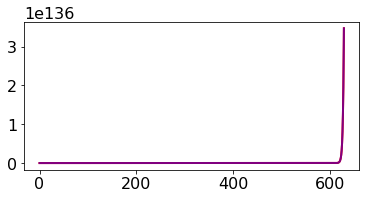

In [9]:
# dirfig =  "C:/Users/ashwi/Documents/tex/lec/drives/figures/"
dirfig =  "D:/tex/lec/drives/figures/"
pl.figure(531, figsize = (6,6))
pl.rc('font', size = 16)
pl.subplot(2,1,1)
pl.plot(Tta,  isd, 'r', Tta,isq ,'purple' ,lw =2)
# t1w = np.pi*2*45
# t2w = np.pi*2*60
# pl.xlim(t1w,t2w)
# # pl.xlim(0,tend)
# pl.axhline(0.75)
# pl.axhline(-0.75)
# pl.ylabel(r'$i_{s\alpha}, \i_{s\beta}$' )
# pl.xticks(np.linspace(t1w,t2w,5))
# pl.yticks(np.linspace(-1.0,1.0,5))
# pl.ylim(-1.0,1.0)
# ax1 = pl.subplot(2,1,2)
# ax1.plot(Tta, isd, 'tomato', lw =3, label = r'$i_{sd}$')
# ax1.plot(t1w+1,0.26,'o', c = 'tomato')
# pl.text(t1w+2,0.28, 'i = {0:1.3f}'.format(isd[-1]), fontsize = 12)
# ax1.plot(Tta,isq, 'purple', lw =3, label = r'$i_{sq}$')
# ax1.plot(Tta,psird, 'magenta', lw=2)
# ax1.set_ylabel(r'$i_{sd}, \i_{sq}$' )
# ax1.set_xlabel(r'$\omega t$')
# ax2 = ax1.twinx()
# ax2.plot(Tta,FCangle, 'olive', lw =2)
# pl.rcParams['legend.fontsize']=12
# ax1.legend(loc = 'upper left')

#pl.axhline(1.0)
#pl.axhline(-1.0)

# t1w = np.pi*2*45
# t2w = np.pi*2*60
# ax1.set_xlim(t1w,t2w)
# ax1.set_xticks(np.linspace(t1w,t2w,5))
# ax1.set_yticks(np.linspace(0,1.0,6))
# ax1.set_ylim(-0.1,1.0)
# ax2.set_ylim(0,3.14)
# pl.savefig(dirfig + "FOCurrentsvst.pdf", bbox_inches = 'tight', transparent = True)

# pl.figure(533, figsize = (4,4))
# pl.rc('font', size = 16)
# pl.rcParams['axes.titlesize']=14
# pl.plot(isd,isq,'crimson', lw =2, label = 'Field currents')
# # pl.plot(psird, psirq, 'blue', lw =4 , label = "actual")
# # pl.axhline(0)
# pl.axvline(0)
# pl.arrow(0,0,psird[-1],psirq[-1], fc = 'magenta', ec = 'magenta',  head_width = 0.05\
#          ,length_includes_head = True, lw =3)
# pl.arrow(0,0,isd[-1],isq[-1], fc = 'crimson', ec = 'crimson',  head_width = 0.05\
#          ,length_includes_head = True, lw =3)
# pl.arrow(0,0,isd[-1],0, fc = 'coral', ec = 'coral',  head_width = 0.05\
#          ,length_includes_head = True, lw =3)
# pl.arrow(isd[-1],0,0,isq[-1], fc = 'coral', ec = 'coral',  head_width = 0.05\
#          ,length_includes_head = True, lw =3)
# pl.text(psird[-1]-0.05,psirq[-1]+0.08, r'$\vec{\psi}_r$', fontsize=16 )
# pl.xlabel(r'$d}$')
# pl.ylabel(r'$q$')
# pl.xlim(-0.01,1.0)
# pl.ylim(-0.02,1.0)
# # pl.xticks(np.linspace(-1.0,1.0,5))
# # pl.axis('equal')
# pl.rcParams['legend.fontsize']=9
# # pl.legend(loc = 'lower left', bbox_to_anchor = (0.8,0))
# pl.title('Field Coordinates')
# pl.savefig(dirfig + "FOXYvectors.pdf", bbox_inches = 'tight', transparent = True)


# pl.figure(536, figsize = (4,4))
# pl.rc('font', size = 16)
# pl.rcParams['axes.titlesize']=14
# pl.plot(isd,isq,'crimson', lw =2, label = 'Field currents')
# # pl.plot(psird, psirq, 'blue', lw =4 , label = "actual")
# # pl.axhline(0)
# pl.axvline(0)
# pl.arrow(0,0,psird[-1],psirq[-1], fc = 'magenta', ec = 'magenta',  head_width = 0.05\
#          ,length_includes_head = True, lw =3)
# pl.arrow(0,0,isd[-1],isq[-1], fc = 'crimson', ec = 'crimson',  head_width = 0.05\
#          ,length_includes_head = True, lw =3)
# pl.arrow(0,0,isd[-1],0, fc = 'coral', ec = 'coral',  head_width = 0.05\
#          ,length_includes_head = True, lw =3)
# pl.arrow(isd[-1],0,0,isq[-1], fc = 'coral', ec = 'coral',  head_width = 0.05\
#          ,length_includes_head = True, lw =3)

# pl.xlabel(r'$d}$')
# pl.ylabel(r'$q$')
# # pl.xlim(0,1.0)
# # pl.ylim(-0.02,1.0)
# # pl.xticks(np.linspace(-1.0,1.0,5))
# pl.axis('equal')
# pl.rcParams['legend.fontsize']=9
# # pl.legend(loc = 'lower left', bbox_to_anchor = (0.8,0))
# pl.title('Field Coordinates')
# # pl.savefig(dirfig + "FOXYvectorsFull.pdf", bbox_inches = 'tight', transparent = True)
# pl.show()
# print(isd[-1], isq[-1])